# Credit Card Fraud Detection

## Intoroduction

Credit card fraud detection has emerged as a critical challenge in the financial sector. Losses from fraudulent activities reach billions of dollars annually and are showing an upward trend due to the increasing digitalization of financial transactions. The significance of this problem extends beyond direct economic losses. Fraud incidents can severely impact customer trust, damage financial institutions' reputations, and require substantial resources for investigation and resolution. 

Credit card fraud detection represents a classic anomaly or outlier detection problem. Fraudulent transactions constitute rare, abnormal patterns within the vast amount of legitimate financial activities. Unlike traditional classification tasks, the inherent nature of fraud detection presents unique challenges due to the extreme imbalance between normal and fraudulent transactions.

In this analysis, we leverage various unsupervised learning algorithms to tackle the challenges of visualizing high-dimensional credit card transaction data and detecting anomalous patterns, namely fraudulent activities. By employing techniques such as t-SNE and PCA for dimensionality reduction, we will try to transform multi-feature transaction data into interpretable visualizations. 

Later, we will try to implement robust anomaly detection algorithms using Isolation Forest and One Class SVM models. These algorithms will help to identify suspicious transactions that deviate from normal spending behaviors. The benefit of the mentioned algorithms is that they don't need data to be labeled.  

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, f1_score

from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, ParameterGrid

## Dataset

The dataset for this project is publicly available on Kaggle: [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data). This dataset contains transactions made by European cardholders in 2013. 

To comply with GDPR, the dataset does not contain the original features. Instead, the PCA algorithm was applied, and the resulting principal components were included in the dataset. The time and amount fields are original features, though.

Let's load the dataset and look inside.

In [2]:
csv_file = os.path.join('./data', 'creditcard.csv')

In [3]:
df = pd.read_csv(csv_file)
df.shape

(284807, 31)

So, the dataset has 31 features and 284807 rows.

Let's figure out the data types:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data Cleaning

I want to remove Time and Amount from the dataset as I believe those are not relevant to the class of the transaction. 

But let's check the correlation coefficients:

In [6]:
df[['Class', 'Time', 'Amount']].corr()

,Class,Time,Amount
Class,1.000000,-0.012323,0.005632
Time,-0.012323,1.000000,-0.010596
Amount,0.005632,-0.010596,1.000000


As you can see, correlations are close to 0. So, let's drop the columns 

In [7]:
df = df.drop(columns=['Time', 'Amount'])

Let's see if we have missing values:

In [8]:
print(f"Number of missed values: {df.isna().sum().sum()}")

Number of missed values: 0


There are no missing values. The dataset was pre-processed and the PCA algorithm was applied. That's why there are no issues with missing values.

Let's take a look at if the dataset is balanced. Fraudulent activities constitute rare events compared to the vast sea of legitimate transactions, making me anticipate that the dataset is hugely unbalanced.

To better visualize it, I will use a logarithmic scale for the histogram:

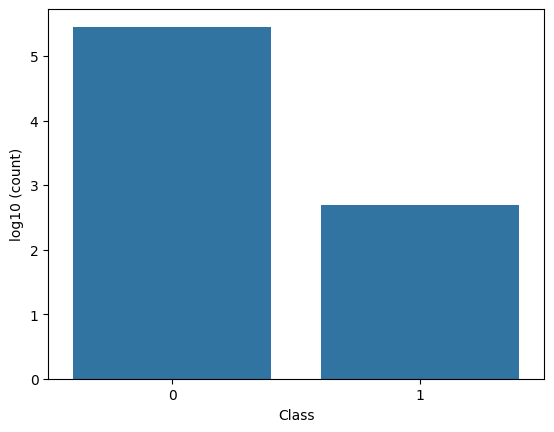

In [9]:
ax = sns.barplot(df.groupby('Class')['Class'].count().apply(np.log10))
ax.set(xlabel='Class', ylabel='log10 (count)')
plt.show()

The dataset is highly unbalanced. It differs approximately by three orders of magnitude.

Let's see if our model will be able to deal with this problem.

## Exploratory Data Analysis 

<Axes: >

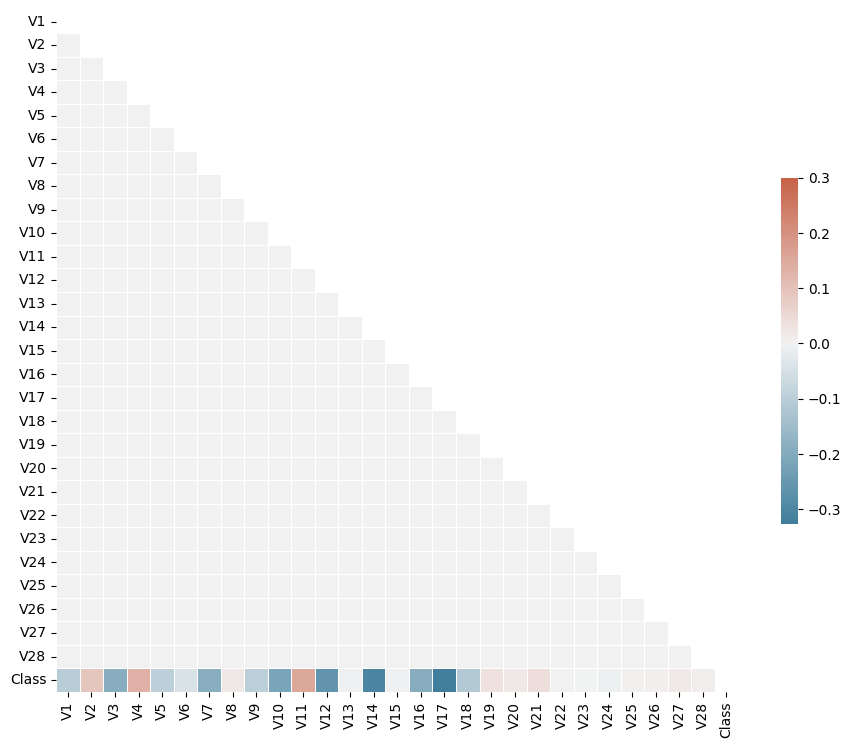

In [10]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

The features are not correlated. It is expected since we know that the features are the principal components.

We can see that there are a lot of features correlated with the Class. But there are a bunch of them that lightly or do not at all correlate with the target variable. Let's remove them. 

In [11]:
df = df[corr[corr['Class'].abs()>0.01].index]
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V12,V14,V16,V17,V18,V19,V20,V21,V27,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.133558,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.008983,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,-0.055353,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.062723,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.219422,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,2.711941,4.626942,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.943651,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.915802,-0.675143,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.068472,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.063119,-0.510602,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.004455,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,-0.962886,0.449624,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.108821,0


<Axes: >

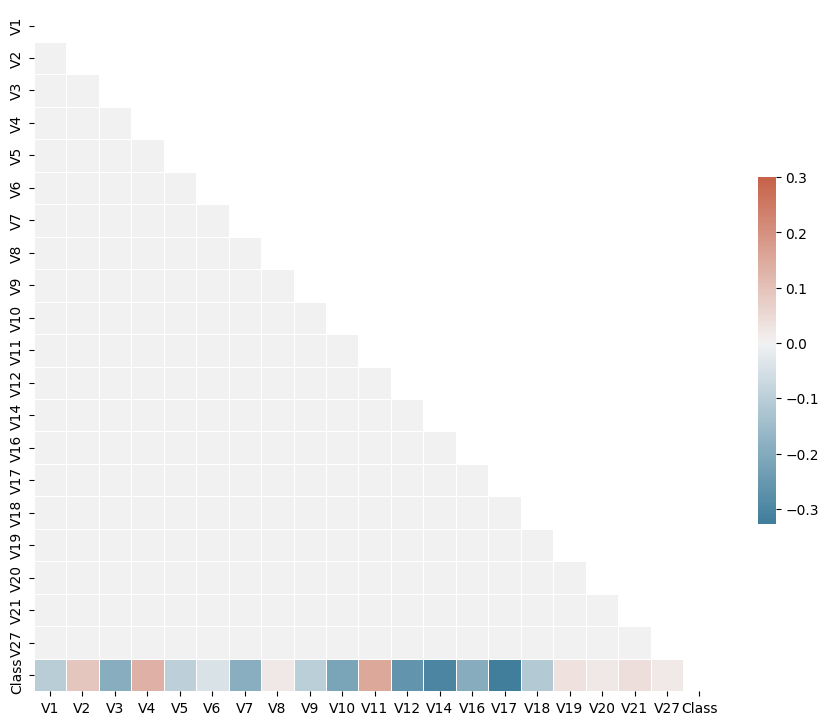

In [12]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

Let's take a look at the histograms of several highly correlated features:

<Axes: xlabel='V11', ylabel='Percent'>

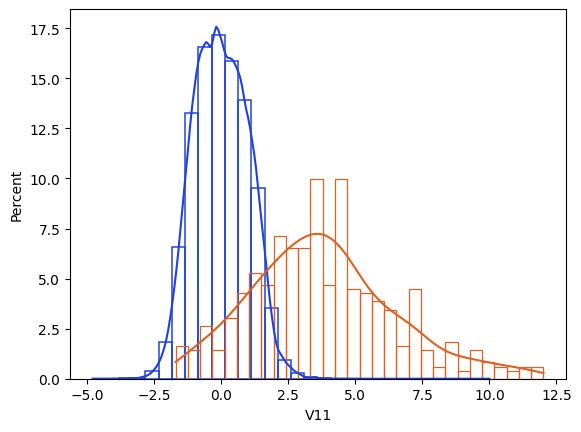

In [38]:
ax = sns.histplot(data=df[df['Class']==0], x='V11', stat="percent", bins=30, fill=False, kde=True, color='#2040df')
sns.histplot(data=df[df['Class']==1], x='V11', stat="percent", bins=30, fill=False, kde=True, color='#df6020', ax=ax)

<Axes: xlabel='V14', ylabel='Percent'>

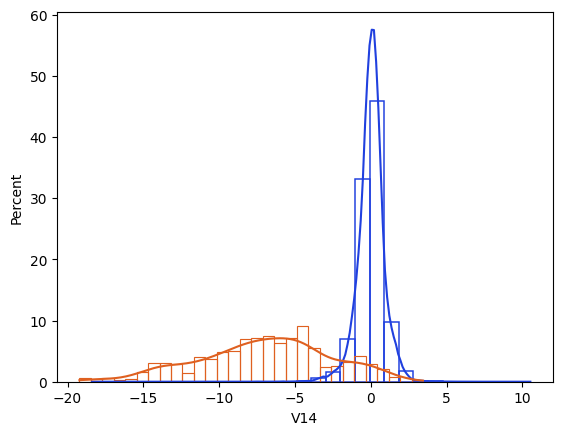

In [39]:
ax = sns.histplot(data=df[df['Class']==0], x='V14', stat="percent", bins=30, fill=False, kde=True, color='#2040df')
sns.histplot(data=df[df['Class']==1], x='V14', stat="percent", bins=30, fill=False, kde=True, color='#df6020', ax=ax)

Now, I want to see if there are outliers. For that, I will use a boxplot.

<Axes: >

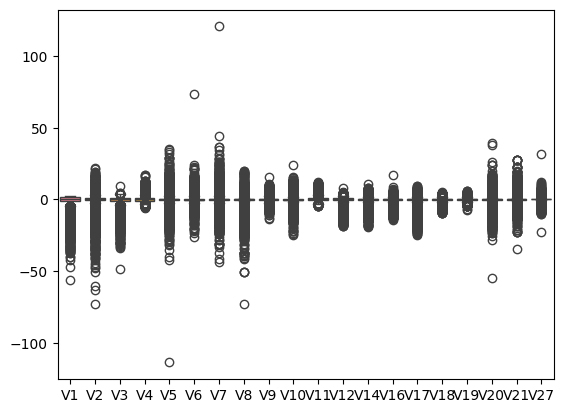

In [34]:
sns.boxplot(data=df.drop(columns=['Class']))

A lot of outliers. But I'm not going to remove them from the dataset. I believe it will be closer to the real-world scenario.

But for the sake of education, let's try to log-transform the data. It would help us reduce the impact of outliers.  

In [16]:
scaled = MinMaxScaler().fit_transform(df.drop(columns=['Class']))

tr = FunctionTransformer(lambda x: np.log1p(x+0.1)).fit_transform(scaled)

norm = StandardScaler().fit_transform(tr)

<Axes: >

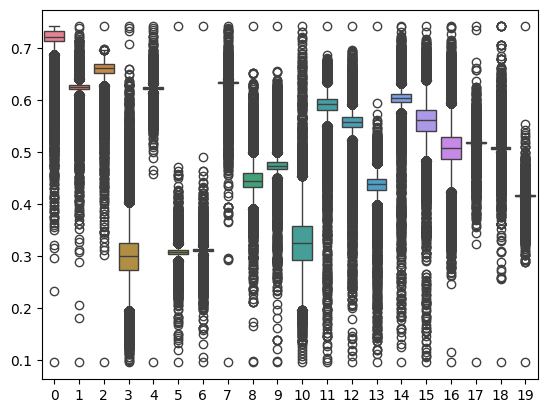

In [17]:
sns.boxplot(data=tr)

Looks nicer. At least we can see boxes in the boxes on the chart. 

### Unsupervised Algorithms for High Dimensional Data Visualization

We managed to reduce the dimensionality by removing uncorrelated features. But it didn't help much. We still have too many features. 

Let's try to use two different dimensionality reduction algorithms: PCA and t-SNE.

PCA, we all know. So, I will not spend time describing it.

t-distributed stochastic neighbor embedding or t-SNE was not covered in the course. It is considered to be a better option for the visualization of highly dimensional data. It can separate clusters that are not linearly separable. However, it is not used for dimensionality reduction mostly because of not reproducible results. 

The algorithm first converts the high-dimensional Euclidean distances between data points into conditional probabilities that represent similarities (using a Gaussian distribution). Then, it creates a similar probability distribution in the low-dimensional space (using a t-distribution) and minimizes the difference between these two distributions using the Kullback-Leibler divergence.

There is one issue. The algorithms like t-SNE or One Class SVM we will use later are computationally intensive. That's why, in most of the further cases, I will use a smaller subsample of the dataset.

Because the dataset is highly unbalanced, I will take all the fraud transactions and 50,000 randomly selected regular transactions.

In [18]:
x_train = pd.concat([df[df['Class']==1], df[df['Class'] == 0].sample(n=50000, replace=False, random_state=1)])

#### t-SNE

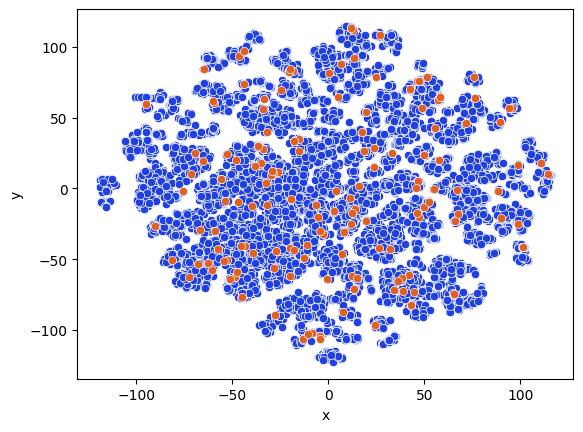

In [19]:
tsne_pip = Pipeline(steps = [('norm', StandardScaler()),
                             ('reduct', TSNE(n_components=2, 
                                             learning_rate='auto', 
                                             perplexity=50))])

proj = tsne_pip.fit_transform(x_train.drop(columns=['Class']))

tsne_df = pd.DataFrame(proj, columns=['x', 'y'])

tsne_df['class'] = x_train['Class']

ax = sns.scatterplot(data=tsne_df[tsne_df['class']==0], x="x", y="y", color='#2040df')
sns.scatterplot(data=tsne_df[tsne_df['class']==1], x="x", y="y", color='#df6020', ax=ax)
plt.show()

#### PCA

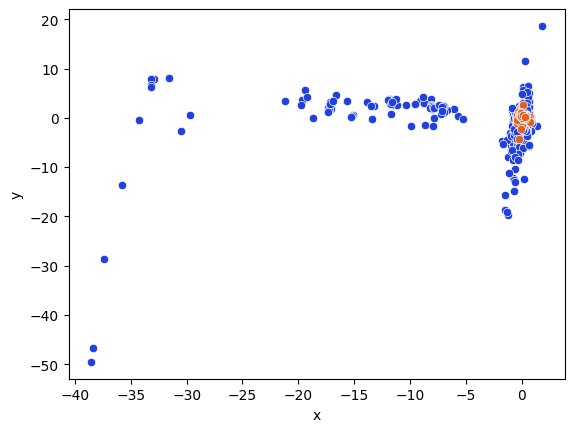

In [20]:
pca_pip = Pipeline(steps = [('norm', StandardScaler()),
                            ('reduct', PCA(n_components=2))])

proj = pca_pip.fit_transform(x_train.drop(columns=['Class']))

pca_df = pd.DataFrame(proj, columns=['x', 'y'])
pca_df['class'] = x_train['Class']

ax = sns.scatterplot(data=pca_df[pca_df['class']==0], x="x", y="y", color='#2040df')
sns.scatterplot(data=pca_df[pca_df['class']==1], x="x", y="y", color='#df6020', ax=ax)
plt.show()

As you can see, both algorithms were not able to make fraud transactions visually separable.

## Model Selection

In [21]:
# The results of classification models are [-1; 1]. 
# This function will convert it to be consistent with the class from the dataset.
# the range of which is [0, 1].
def result_convert(r):
    r = np.where(r == 1, 0, r)
    r = np.where(r == -1, 1, r)
    return r

#### One Class SVM

One Class SVM is an unsupervised learning algorithm. It works by learning a decision boundary that separates the normal data (the majority class) from the origin in a high-dimensional feature space. In other words, it draws the smallest hypersphere, which contains the majority of the data points. The algorithm maps the input data to a higher-dimensional feature space using a kernel function (like RBF)

It will classify new points as either normal (inside the boundary) or anomalous (outside the boundary). The decision boundary is optimized to include as much of the normal data as possible while remaining as tight as possible. It is controlled by a parameter $\nu$ that determines the trade-off between the volume of the region and the number of training points it can exclude as potential anomalies.

In [22]:
pipe = Pipeline(steps=[ ('norm', StandardScaler()),
                       ('clust', OneClassSVM(kernel='rbf', 
                                             degree=3, 
                                             gamma=0.1,
                                             nu=0.05, 
                                             max_iter=-1))])

In [23]:
pipe.fit(x_train[x_train['Class']==0].drop(columns=['Class']))

Pipeline(steps=[('norm', StandardScaler()),
                ('clust', OneClassSVM(gamma=0.1, nu=0.05))])

In [24]:
res = result_convert(pipe.predict(df.drop(columns=['Class'])))

In [25]:
print(classification_report(df['Class'], res))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    284315
           1       0.03      0.89      0.05       492

    accuracy                           0.94    284807
   macro avg       0.51      0.92      0.51    284807
weighted avg       1.00      0.94      0.97    284807



In [26]:
confusion_matrix(df['Class'], res)

array([[268111,  16204],
       [    54,    438]])

#### Isolation Forest

Isolation Forest stands out as an efficient and powerful unsupervised learning algorithm for anomaly detection. It operates on the key principle that anomalies are instances that are both rare and distinct, making them easier to isolate than normal points in the data.

The algorithm creates multiple isolation trees by recursively partitioning the data with randomly selected features and, importantly, randomly selected split points. Anomalies typically result in shorter average path lengths (requiring fewer splits to isolate) compared to normal instances. It leads to an efficient anomaly scoring mechanism based on these path lengths. 

One of the key advantages of Isolation Forest is its computational efficiency and its ability to handle high-dimensional data without requiring distance calculations. It makes the models particularly suitable for large-scale applications in fraud detection, system health monitoring, and other anomaly detection scenarios.

In [27]:
pipe = Pipeline(steps=[
   ('norm', StandardScaler()),
   ('clust', IsolationForest(n_estimators=100, random_state=42))])

In [28]:
pipe.fit(x_train[x_train['Class']==0].drop(columns=['Class']))

Pipeline(steps=[('norm', StandardScaler()),
                ('clust', IsolationForest(random_state=42))])

In [29]:
res = result_convert(pipe.predict(df.drop(columns=['Class'])))

In [30]:
print(classification_report(df['Class'], res))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    284315
           1       0.03      0.87      0.07       492

    accuracy                           0.96    284807
   macro avg       0.52      0.91      0.52    284807
weighted avg       1.00      0.96      0.98    284807



#### Hyperparameter Optimization 

Because, as mentioned before, the Isolation Forest is computationally more efficient than the One-Class SVM, and the performance is comparable (recalls for OneClassSVM are 94% and 89% while for IsolationForest are 96% and 87%, respectively), I am selecting the later for the further tuning.

In [31]:
param_grid = {'clust__n_estimators': [100, 500, 800], 
              'clust__max_samples': [100, 300, 500], 
              'clust__max_features': [1, 5, 10]
             }

f1sc = make_scorer(f1_score, average='micro')

grid = GridSearchCV(pipe,  
                    param_grid,
                    scoring=f1sc, 
                    refit=True,
                    cv=5, 
                    return_train_score=True)

grid.fit(df.drop(columns=['Class']), df['Class'])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('norm', StandardScaler()),
                                       ('clust',
                                        IsolationForest(random_state=42))]),
             param_grid={'clust__max_features': [1, 5, 10],
                         'clust__max_samples': [100, 300, 500],
                         'clust__n_estimators': [100, 500, 800]},
             return_train_score=True,
             scoring=make_scorer(f1_score, response_method='predict', average=micro))

In [32]:
res = result_convert(grid.best_estimator_.predict(df.drop(columns=['Class'])))

In [33]:
print(classification_report(df['Class'], res))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98    284315
           1       0.05      0.84      0.09       492

    accuracy                           0.97    284807
   macro avg       0.52      0.90      0.54    284807
weighted avg       1.00      0.97      0.98    284807



## Results

It is not that straightforward to conclude on the results. 

The simple part is that IsolationForest consumes less computational resources while giving similar to OneClassSVM performance. 

Another thing is the performance results overall. At first glance, it looks like the results are outstanding. The accuracy is around 95% for both models we used. But let's dive deeper into analyzing the last classification report of the best estimator.

As you can see from the report above, the recall for regular transactions is 97%. 84% is for fraud. So, the algorithm successfully catches 84% of fraud cases. The problem is that 3% of normal transactions are misclassified as fraud! So, there are a lot of false positives.

Precision for fraud cases is only 5%, which supports the statement above. 

Underlining, even though the algorithms catch most of the anomalies, they generate a lot of noise. This should be considered for later improvements. 

## Conclusion

Both unsupervised anomaly detection algorithms perform well enough on the dataset. They detect around 85% of the fraudulent transactions. But the problem is the relatively high amount of false positive cases. Even though it is only around 5% of the dataset, because the dataset is unbalanced, 3% of the dataset is 1,700% of fraud alert triggers. This is not practical.

In order to improve it, I would try to do the next. First, try to remove outliers from the dataset before anomaly detection.

Another option is to use a hybrid classification algorithm. The unsupervised learning algorithm removes a good bit of the transactions. Now, we could apply supervised learning algorithms like tree ensembles in order to finally classify the fraudulent behavior. 

## Citations

1. Kaggle. (2013). Credit Card Fraud Detection [Data set]. https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data
2. Kemal Erdem (burnpiro). t-SNE clearly explained. (2020, Apr 13). *Towards Data Science.* https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a
3. Milind Sahay. Credit Card Fraud Detection with Machine Learning. (2020, July 9). *Towards Data Science.* https://towardsdatascience.com/credit-card-fraud-detection-with-machine-learning-6cf8e7c78639
4. One-class classification. (2024, October 4). *In Wikipedia.* https://en.wikipedia.org/wiki/One-class_classification
5. Isolation forest. (2024, November 25). *In Wikipedia.* https://en.wikipedia.org/wiki/Isolation_forest